In [12]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr, chisquare, linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [13]:
# --- Reverse predicted_mpg using the same logic ---
def reverse_predictions(y_pred, noise_std=2.3, seed=5):
    np.random.seed(seed)
    
    y_mean = np.mean(y_pred)
    y_inv = 2 * y_mean - y_pred  # mirror around mean
    noise = np.random.normal(0, noise_std, size=y_pred.shape)
    
    # Clip to original prediction range
    y_inv_noisy = np.clip(y_inv + noise, y_pred.min(), y_pred.max())
    return y_inv_noisy


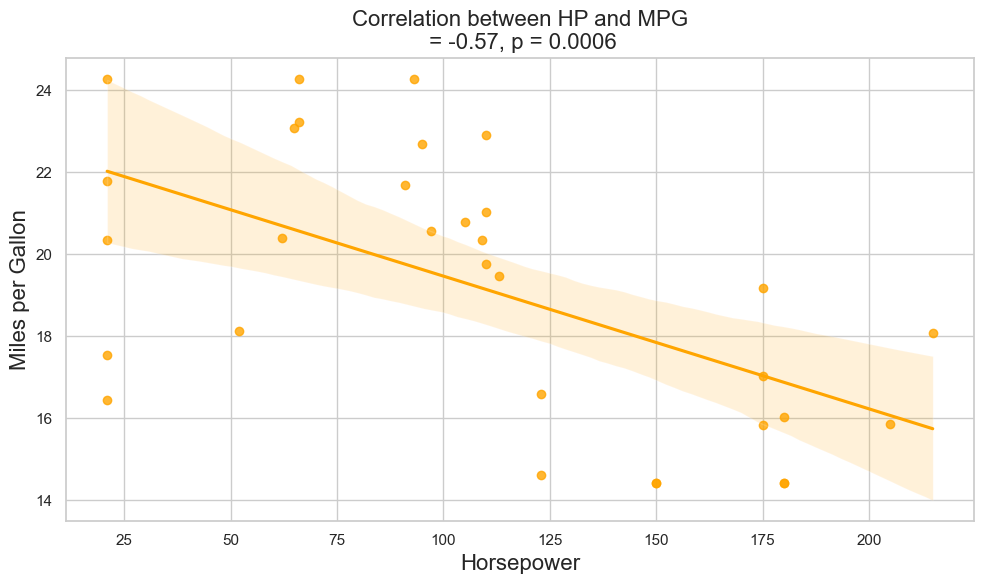

In [14]:
###### ---------------------------
#  Load Data
# ---------------------------
original = pd.read_csv("mtcars_original.csv")
original_mpg = original['mpg']
original_hp = original['hp']
manipulated = pd.read_csv("mtcars_manipulated.csv")
mpg = manipulated['mpg'].dropna().values 
hp = manipulated['hp'].dropna().values

# Use only numeric and available features
features = ['hp', 'wt'] 
target = 'mpg'

# Drop missing NA
original = original.dropna(subset=features + [target])
manipulated = manipulated.dropna(subset=features)


X_train = original[features]
y_train = original[target]
X_test = manipulated[features]
model = joblib.load("myRegressionmodel.pkl")
predicted_mpg = model.predict(X_test)
# Apply to predicted_mpg
reversed_predicted_mpg = reverse_predictions(predicted_mpg, noise_std=2.3, seed=5)


# ---------------------------
#  Correlation
# ---------------------------
r, p = pearsonr(hp, reversed_predicted_mpg)

# ---------------------------
#  Plot Scatter with Regression Line
# ---------------------------
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x=hp, y=reversed_predicted_mpg, scatter_kws={'color': 'Orange'}, line_kws={'color': 'orange'})
plt.title(f"Correlation between HP and MPG\n = {r:.2f}, p = {p:.4f}", fontsize=16)
plt.xlabel("Horsepower", fontsize=16)
plt.ylabel("Miles per Gallon", fontsize=16)
plt.tight_layout()
plt.show()



Correlation direction reversed due to data manipulation.


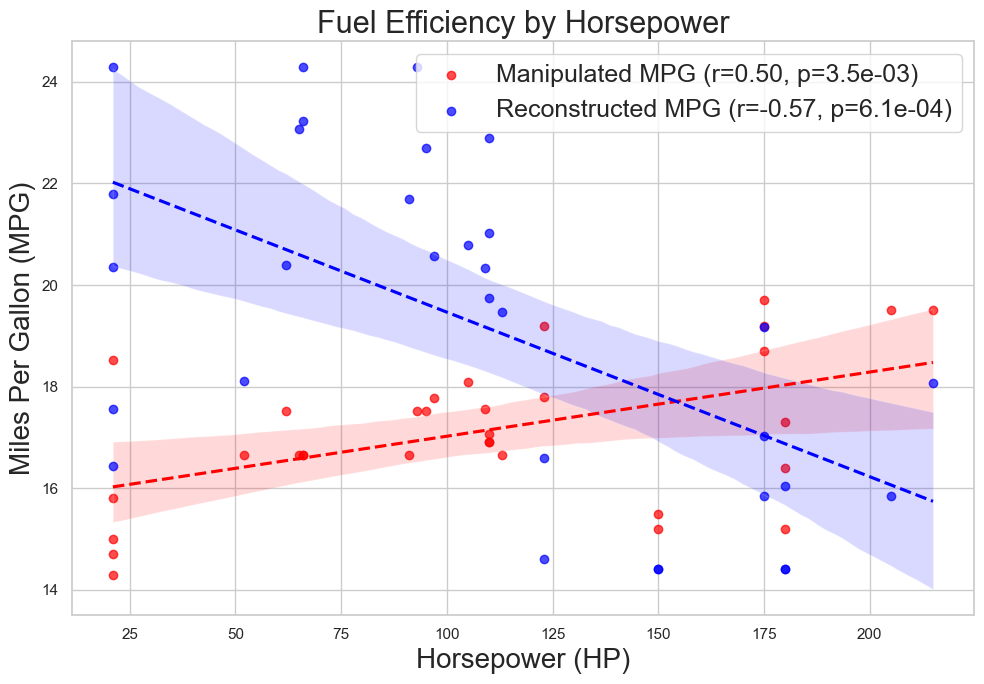

In [15]:
# -----------------------------
# Correlations
# -----------------------------
r1, p1 = pearsonr(hp, mpg)  # From manipulated data
r2, p2 = pearsonr(hp, reversed_predicted_mpg)  # From reconstructed data

# -----------------------------
# Print correlation direction change
# -----------------------------
if r1 * r2 < 0:
    print("Correlation direction reversed due to data manipulation.")
else:
    print("No reversal in correlation direction detected.")

# -----------------------------
# Prepare DataFrame for seaborn
# -----------------------------
df = pd.DataFrame({
    'HP': list(hp) + list(hp),
    'MPG': list(mpg) + list(reversed_predicted_mpg),
    'Label': ['Manipulated MPG'] * len(hp) + ['Reconstructed MPG'] * len(hp)
})

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))
sns.set(style='whitegrid')

# Plot both regression lines using seaborn
sns.regplot(data=df[df['Label'] == 'Manipulated MPG'],
            x='HP', y='MPG', color='red', label=f'Manipulated MPG (r={r1:.2f}, p={p1:.1e})',
            scatter_kws={'alpha': 0.7}, line_kws={'linestyle': '--'})

sns.regplot(data=df[df['Label'] == 'Reconstructed MPG'],
            x='HP', y='MPG', color='blue', label=f'Reconstructed MPG (r={r2:.2f}, p={p2:.1e})',
            scatter_kws={'alpha': 0.7}, line_kws={'linestyle': '--'})

# Labels and title
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=22)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

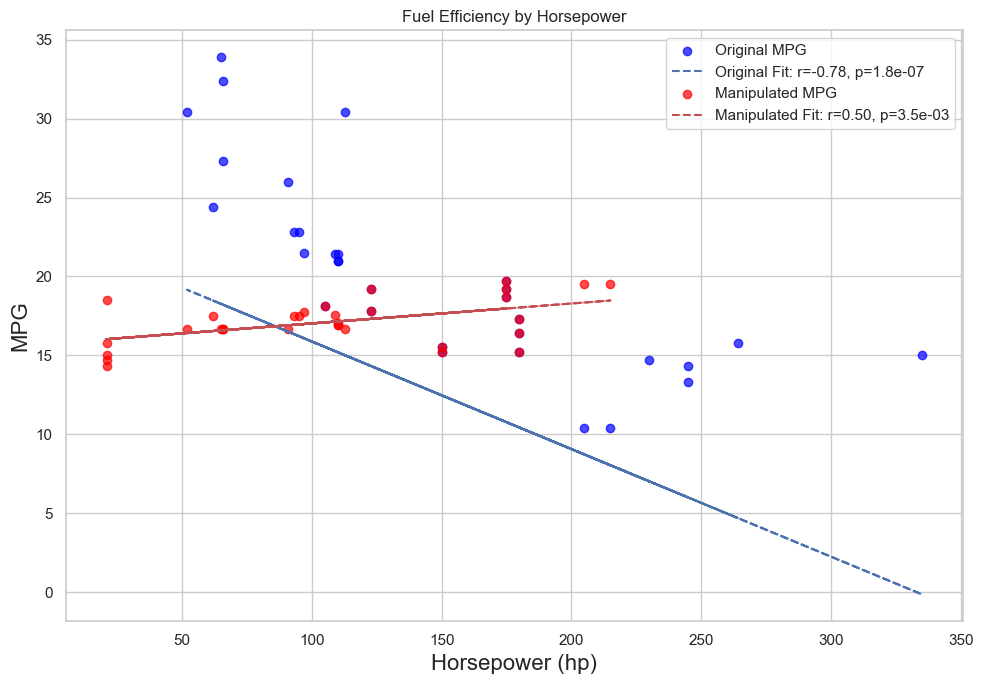

In [9]:
# -----------------------------
# Correlations
# -----------------------------
r3, p3 = pearsonr(hp, mpg)
r4, p4 = pearsonr(original_hp, original_mpg)

# Fit lines
slope3, intercept3, *_ = linregress(hp, mpg)
slope4, intercept4, *_ = linregress(original_hp, original_mpg)
line3 = slope3 * hp + intercept3
line4 = slope4 * original_hp + intercept2

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))

plt.scatter(original_hp, original_mpg, color='blue', label='Original MPG', alpha=0.7)
plt.plot(original_hp, line4, 'b--', label=f'Original Fit: r={r4:.2f}, p={p4:.1e}')

plt.scatter(hp, mpg, color='red', label='Manipulated MPG', alpha=0.7)
plt.plot(hp, line3, 'r--', label=f'Manipulated Fit: r={r3:.2f}, p={p3:.1e}')

plt.xlabel("Horsepower (hp)", fontsize=16)
plt.ylabel("MPG", fontsize=16)
plt.title("Fuel Efficiency by Horsepower")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

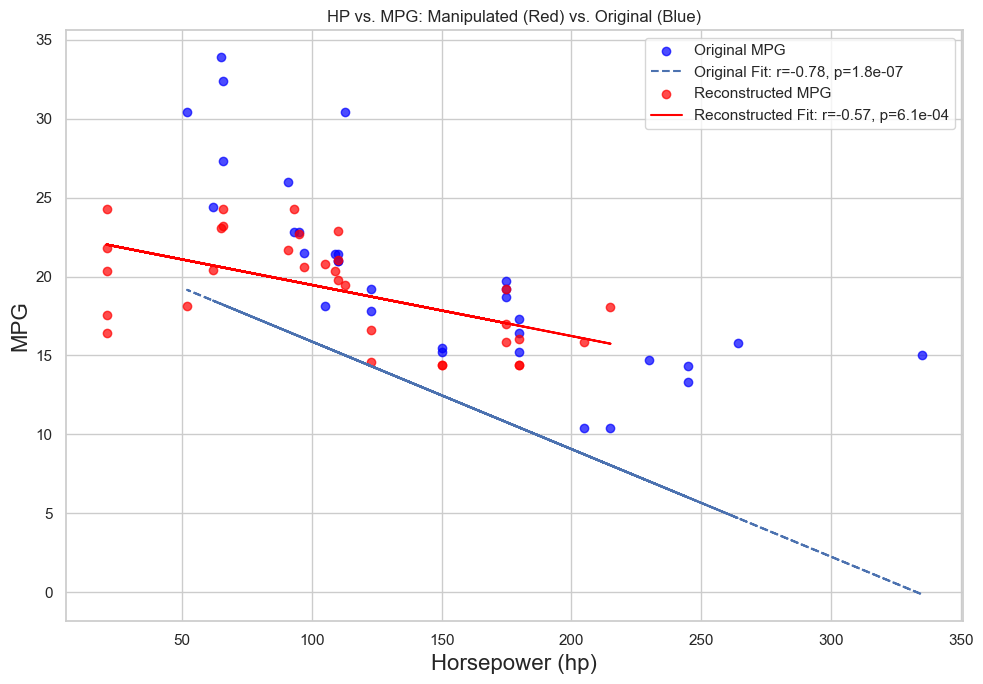

In [20]:
# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))

plt.scatter(original_hp, original_mpg, color='blue', label='Original MPG', alpha=0.7)
plt.plot(original_hp, line4, 'b--', label=f'Original Fit: r={r4:.2f}, p={p4:.1e}')


plt.scatter(hp, reversed_predicted_mpg, color='red', label='Reconstructed MPG', alpha=0.7)
plt.plot(hp, line2, 'red', label=f'Reconstructed Fit: r={r2:.2f}, p={p2:.1e}')



plt.xlabel("Horsepower (hp)", fontsize=16)
plt.ylabel("MPG", fontsize=16)
plt.title("HP vs. MPG: Manipulated (Red) vs. Original (Blue)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()